#### Problem Statement: Churn Prediction:
###### Create a prediction model that use historical data and pertinent features to identify consumers who are most likely to churn.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import kaggle
import zipfile


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import xgboost
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 1.Data Preparation: 

##### 1.1 Data collection and labeling
##### Data Collected from https://www.kaggle.com/datasets/shilongzhuang/telecom-customer-churn-by-maven-analytics

In [60]:
#use the kaggle API to download the dataset
!kaggle datasets download -d shilongzhuang/telecom-customer-churn-by-maven-analytics

telecom-customer-churn-by-maven-analytics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [61]:
# save the downloaded dataset and read only the necessary csv file 
zipfile_name= 'telecom-customer-churn-by-maven-analytics.zip'
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extract('telecom_customer_churn.csv')

In [62]:
# read and display general information about the dataset
df = pd.read_csv('telecom_customer_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

In [63]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [64]:
# shape of the dataset
df.shape

(7043, 38)

In [65]:
# display the columns
df.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')

##### Insight:'Customer Status' is the target feature. 

### 2. Data Cleaning

In [66]:
# normalize the header names
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [67]:
#check for null value
df.isnull().sum()

customer_id                             0
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenure_in_months                        0
offer                                   0
phone_service                           0
avg_monthly_long_distance_charges     682
multiple_lines                        682
internet_service                        0
internet_type                        1526
avg_monthly_gb_download              1526
online_security                      1526
online_backup                        1526
device_protection_plan               1526
premium_tech_support                 1526
streaming_tv                         1526
streaming_movies                  

##### Insight: 14 features contain null values

In [68]:
# Check the value_counts of the features that contain null values
columns_with_null = [col for col in df.columns if df[col].isnull().any()]

for col in columns_with_null:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

avg_monthly_long_distance_charges
[42.39 10.69 33.65 27.82  7.38]
3583

multiple_lines
['No' 'Yes' nan]
2

internet_type
['Cable' 'Fiber Optic' 'DSL' nan]
3

avg_monthly_gb_download
[16. 10. 30.  4. 11.]
49

online_security
['No' 'Yes' nan]
2

online_backup
['Yes' 'No' nan]
2

device_protection_plan
['No' 'Yes' nan]
2

premium_tech_support
['Yes' 'No' nan]
2

streaming_tv
['Yes' 'No' nan]
2

streaming_movies
['No' 'Yes' nan]
2

streaming_music
['No' 'Yes' nan]
2

unlimited_data
['Yes' 'No' nan]
2

churn_category
[nan 'Competitor' 'Dissatisfaction' 'Other' 'Price']
5

churn_reason
[nan 'Competitor had better devices' 'Product dissatisfaction'
 'Network reliability' 'Limited range of services']
20



In [69]:
# There are three main ways of filling out missing values
# drop the null values, fill with 0 or fill with average
# for this we fill out the null values with average of each 
num_types = ['int64', 'float64']
numeric = list(df.select_dtypes(include=num_types))
for col in numeric:
    df[col].fillna(value=df[col].mean(), inplace=True)

In [70]:
df[numeric].isnull().sum()

age                                  0
number_of_dependents                 0
zip_code                             0
latitude                             0
longitude                            0
number_of_referrals                  0
tenure_in_months                     0
avg_monthly_long_distance_charges    0
avg_monthly_gb_download              0
monthly_charge                       0
total_charges                        0
total_refunds                        0
total_extra_data_charges             0
total_long_distance_charges          0
total_revenue                        0
dtype: int64

In [71]:
# for categrical values we either drop the null value 
# or fill with most occuring word in the feature
categorical = list(df.select_dtypes(include='O'))
for col in categorical:
    most_occurring_word = df[col].mode()[0]
    df[col] = df[col].fillna(most_occurring_word)

In [72]:
df[categorical].isnull().sum()

customer_id               0
gender                    0
married                   0
city                      0
offer                     0
phone_service             0
multiple_lines            0
internet_service          0
internet_type             0
online_security           0
online_backup             0
device_protection_plan    0
premium_tech_support      0
streaming_tv              0
streaming_movies          0
streaming_music           0
unlimited_data            0
contract                  0
paperless_billing         0
payment_method            0
customer_status           0
churn_category            0
churn_reason              0
dtype: int64

In [73]:
df.isnull().sum()

customer_id                          0
gender                               0
age                                  0
married                              0
number_of_dependents                 0
city                                 0
zip_code                             0
latitude                             0
longitude                            0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data           

In [90]:
df[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
number_of_dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
zip_code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
number_of_referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
tenure_in_months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
avg_monthly_long_distance_charges,7043.0,25.420517,13.495231,1.010000,14.455000,25.420517,36.395000,49.990000
avg_monthly_gb_download,7043.0,26.189958,17.334960,2.000000,15.000000,26.000000,27.000000,85.000000
monthly_charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000


### 3. Data Exploration

##### Univariate Analysis

In [74]:
#let's explore the target feature 
df.customer_status.value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: customer_status, dtype: int64

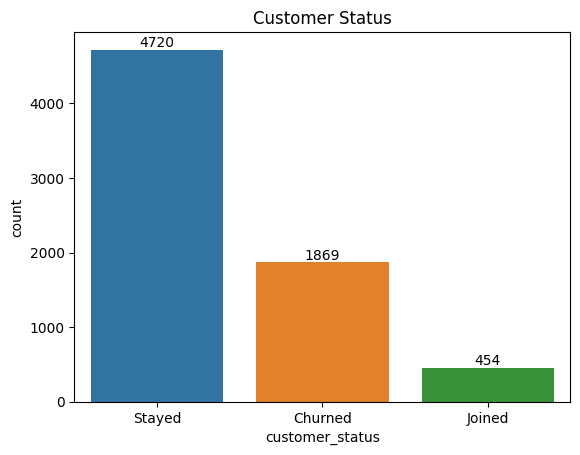

In [75]:
#plot the customer_status feature
plt.title("Customer Status")
ax = sns.countplot(data=df, x='customer_status')
for container in ax.containers:
    ax.bar_label(container)

###### Insight: The number of Churned Customers out numbers the joined customers

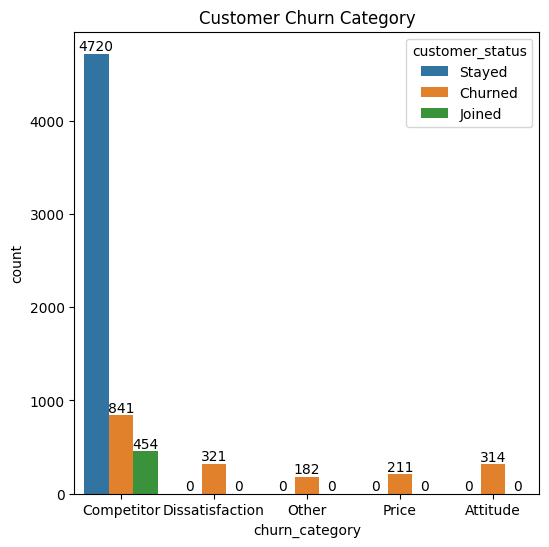

In [76]:
plt.figure(figsize=(6,6))
plt.title("Customer Churn Category")
ax = sns.countplot(data=df, x=df.churn_category, hue=df.customer_status)
for container in ax.containers:
    ax.bar_label(container)

###### Insight: Competitor is the biggest reason for churning

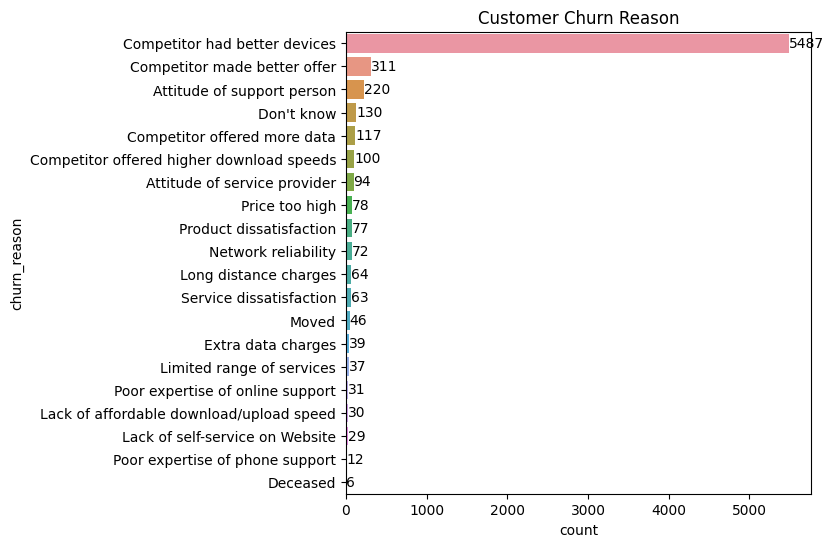

In [77]:
plt.figure(figsize=(6,6))
plt.title("Customer Churn Reason")
ax = sns.countplot(data = df, y='churn_reason',
              order = df['churn_reason'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container)

###### Insight: Most of the reason for churning is "Competitor had better devices"

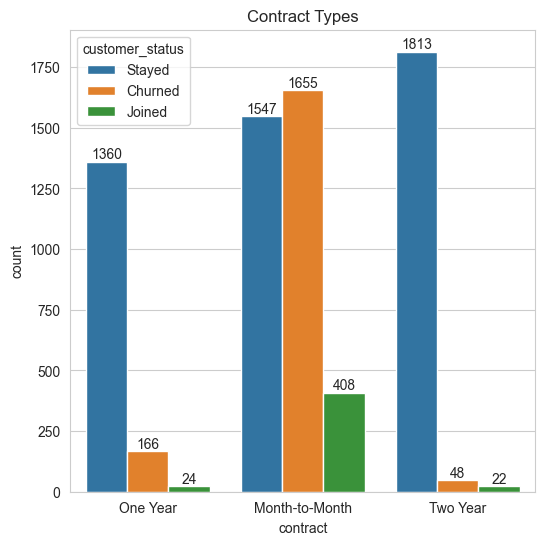

In [120]:
plt.figure(figsize=(6,6))
plt.title("Contract Types")
ax= sns.countplot(data=df, x=df.contract, hue=df.customer_status)
for container in ax.containers:
    ax.bar_label(container)

##### Insight:
###### Customer on month-to-month contract churn the most

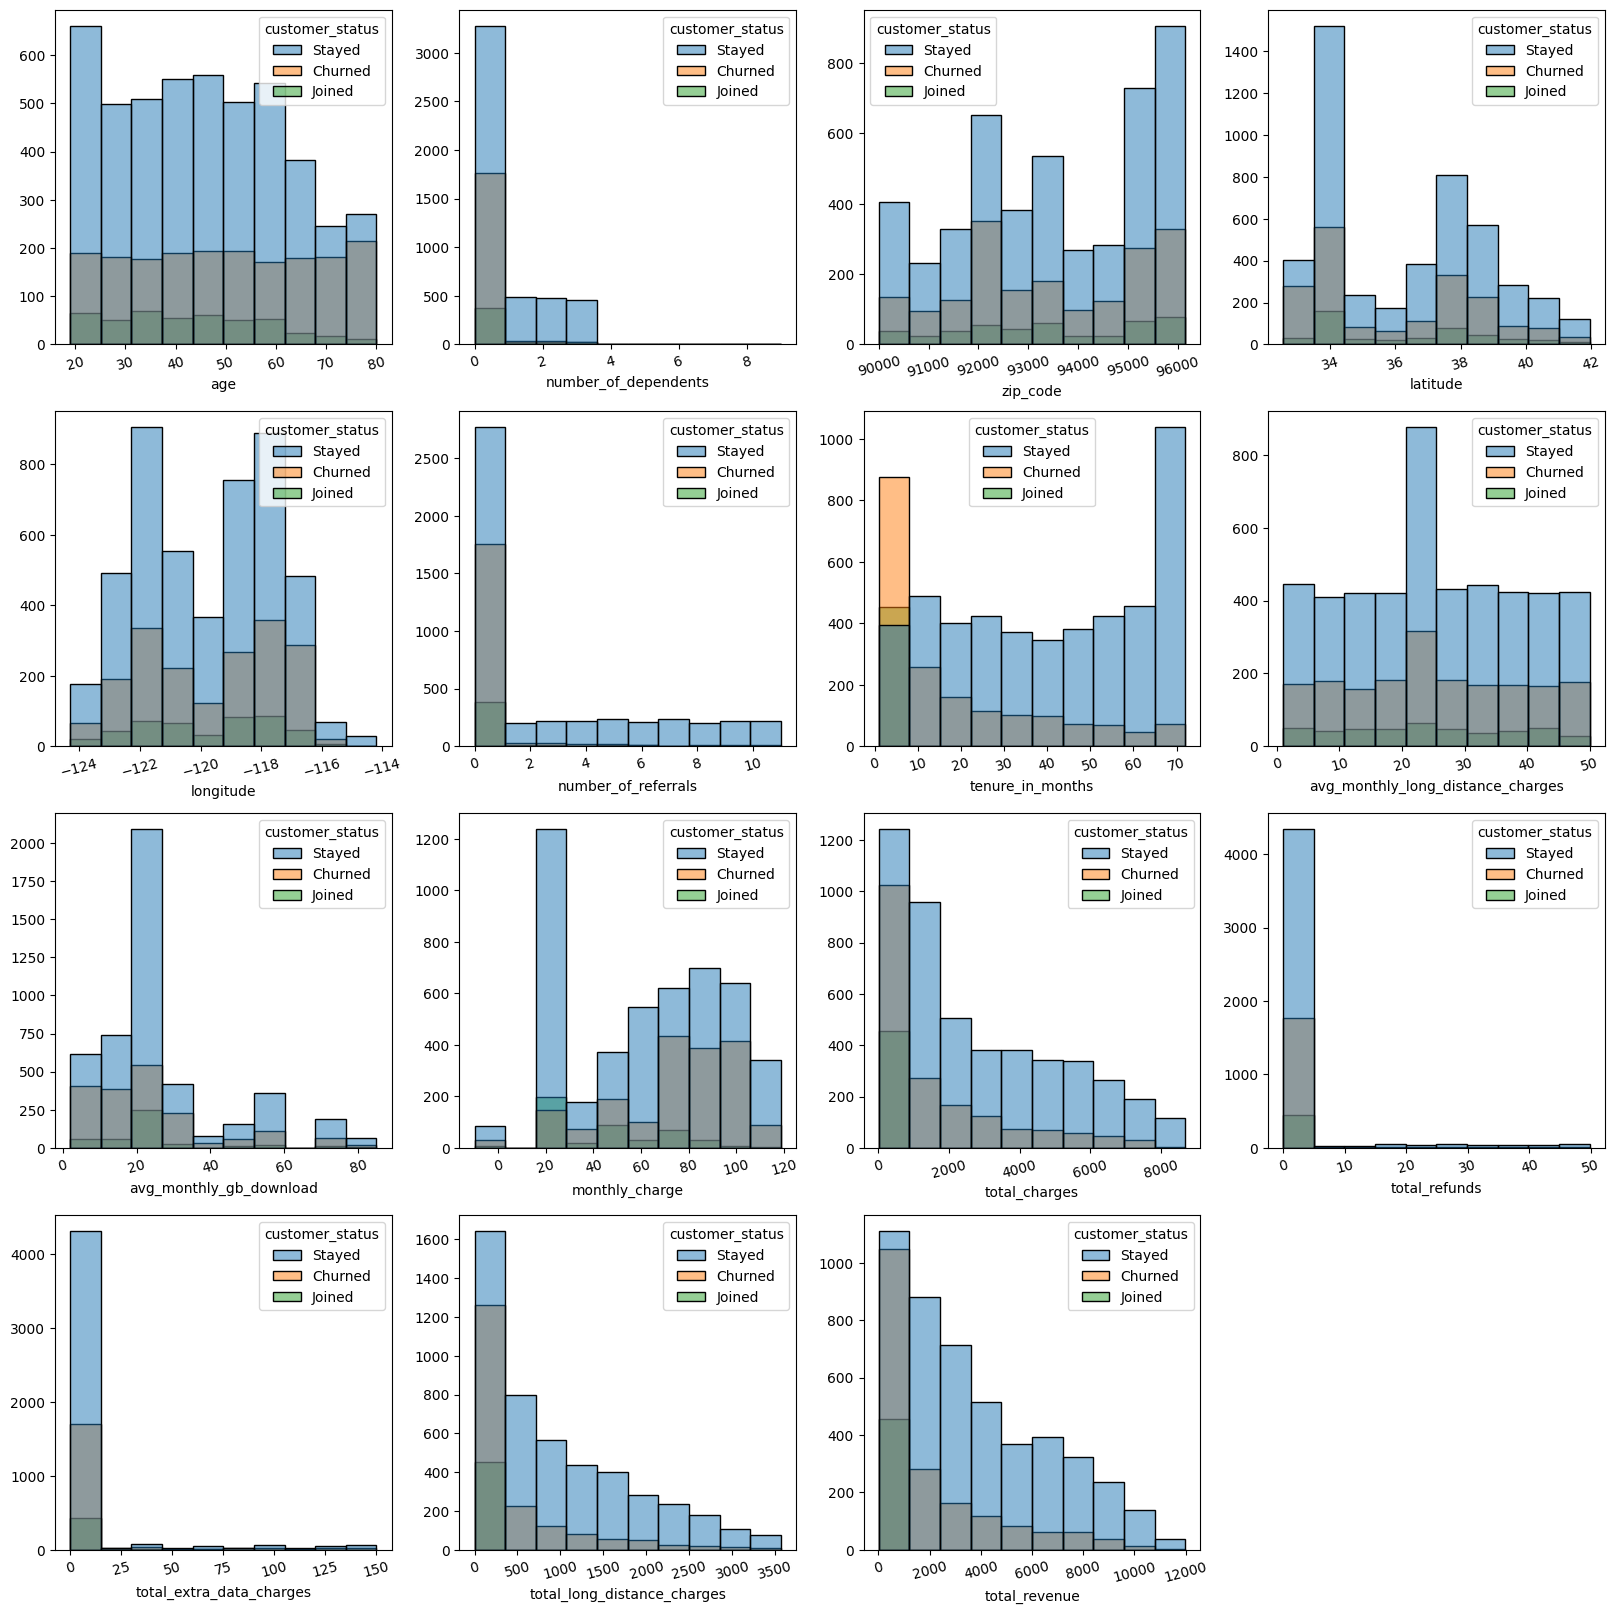

In [80]:
#plot the numeric features 
plt.figure(figsize = (20,20))

j = 1
for col in df[numeric].columns:
    plt.subplot(4,4,j)
    ax = sns.histplot(x = df[col],hue = df['customer_status'], bins=10)
    ax.set( ylabel = None)
    plt.xticks(rotation = 15)
    j += 1

##### Insight:
###### From 'tenure_in_months' we see that new customers Churn the most

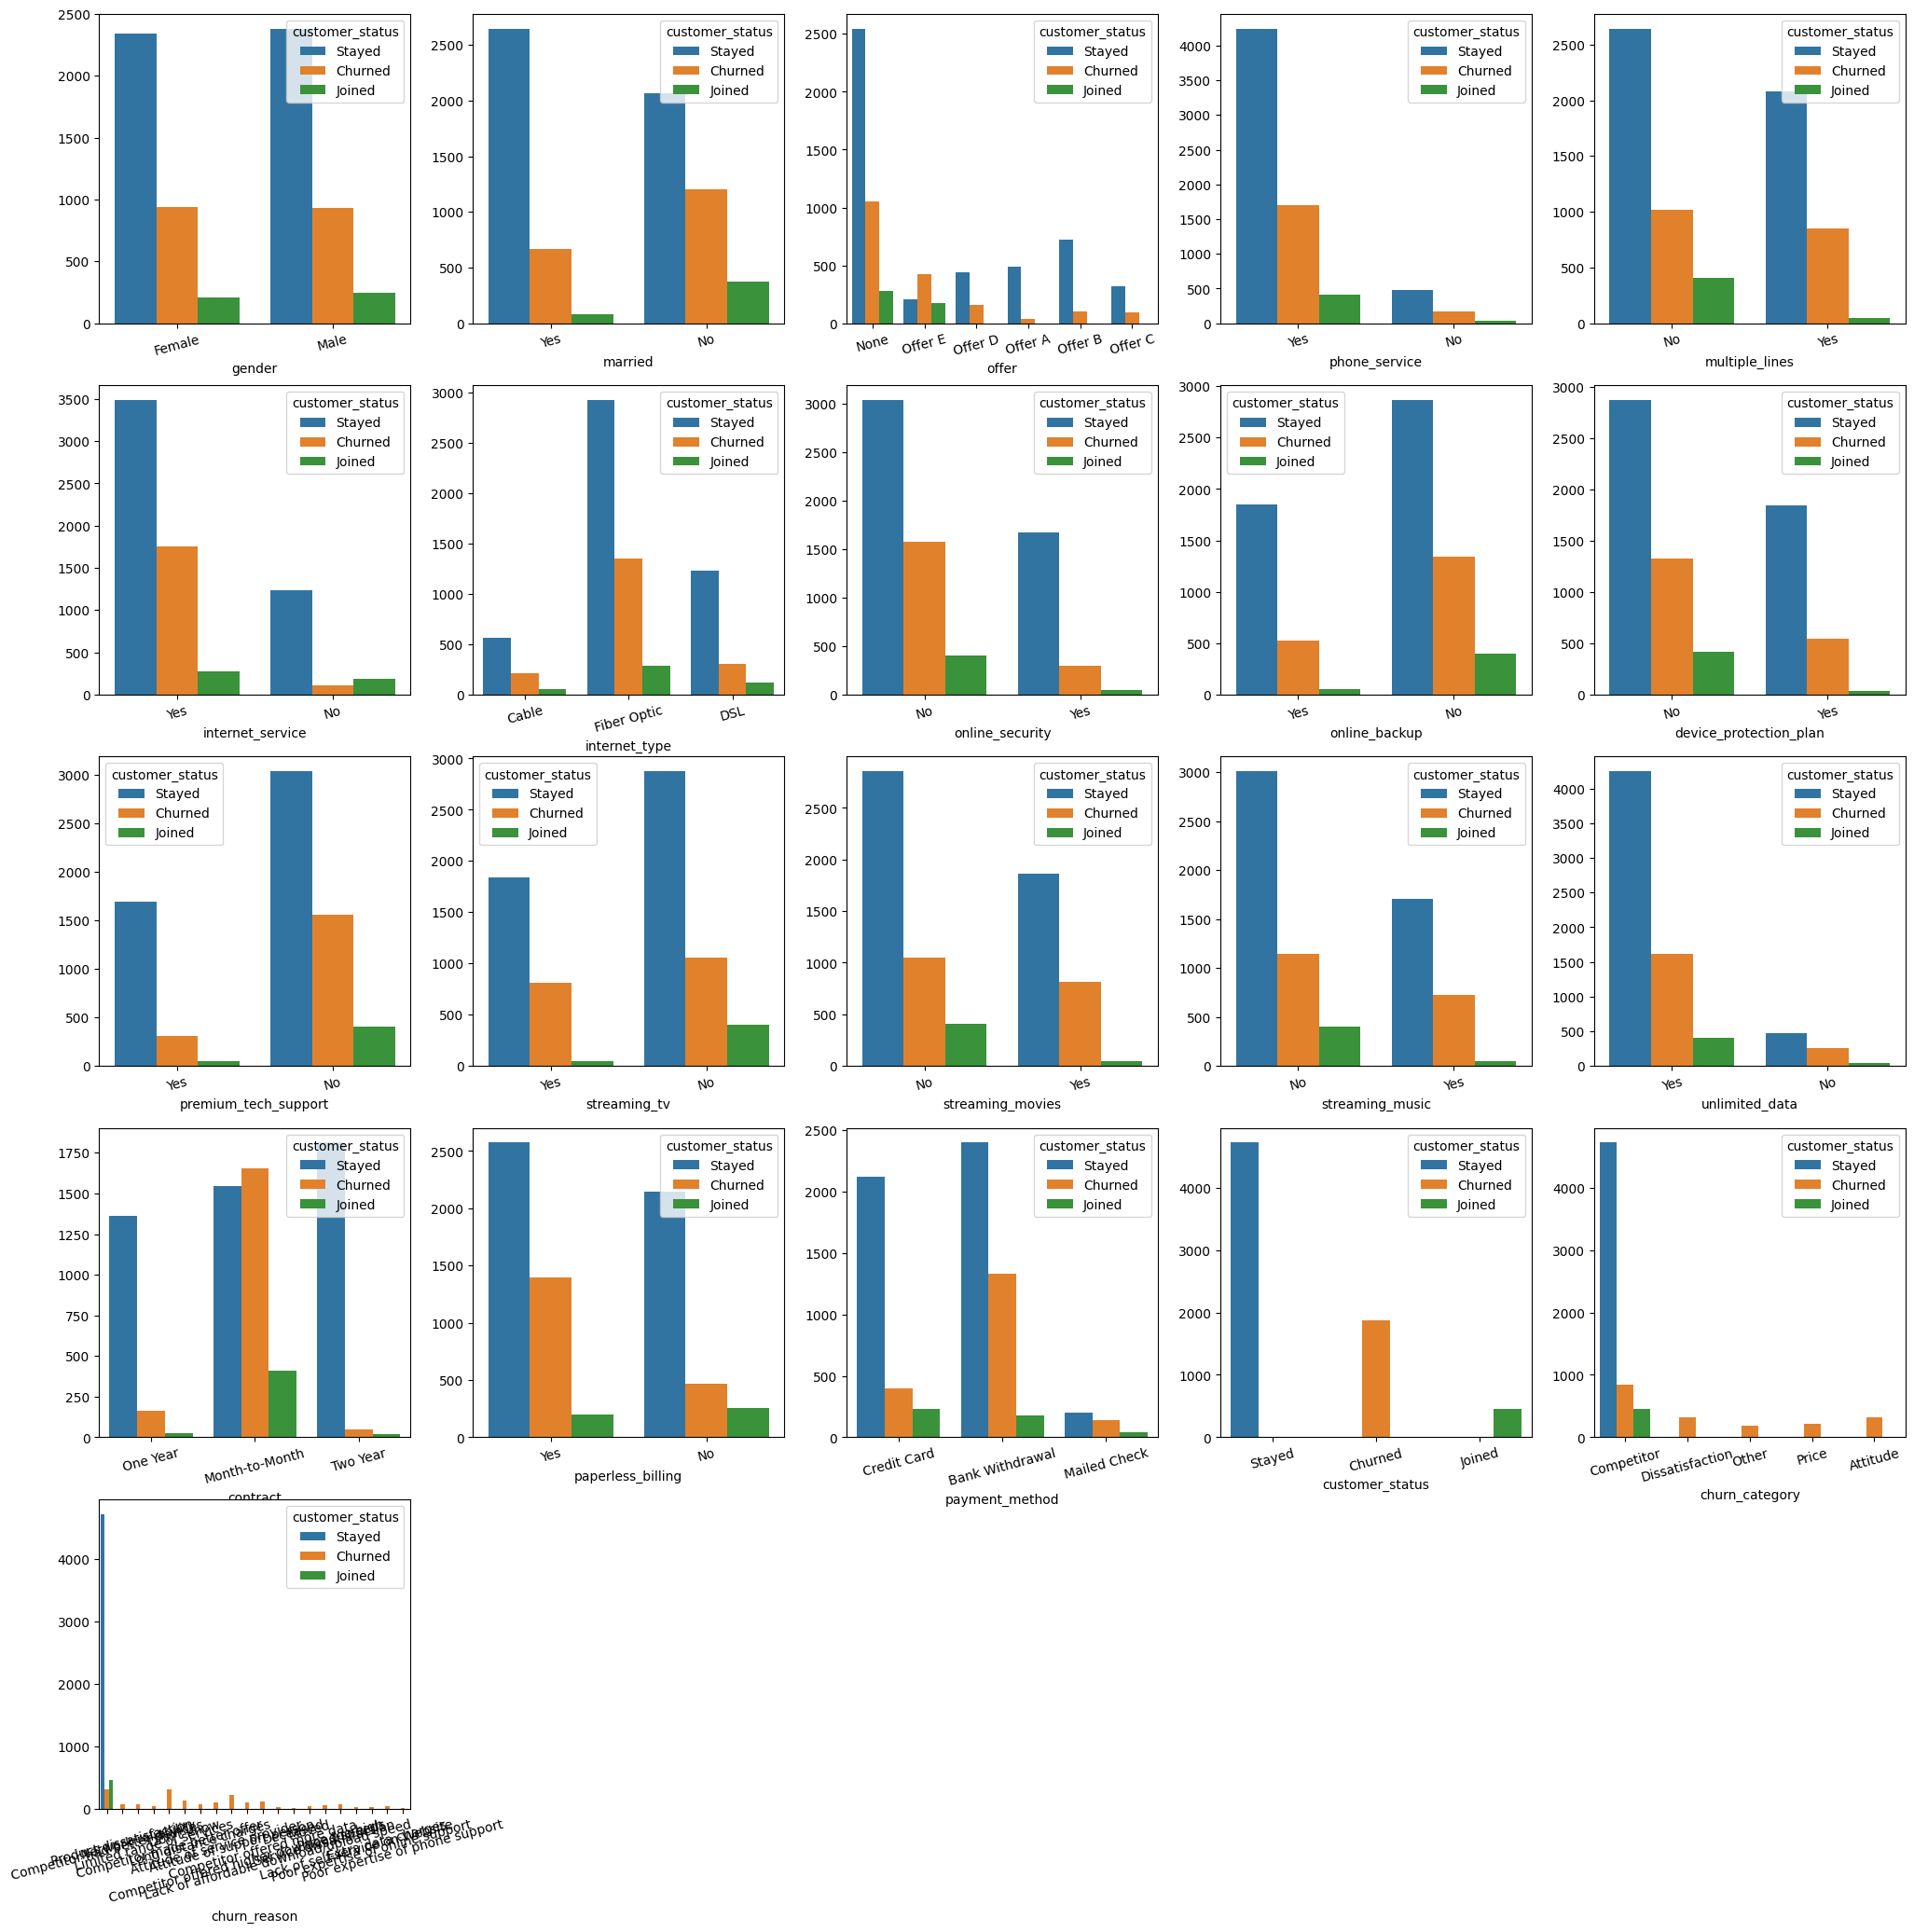

In [94]:
cats = list(df.select_dtypes(include=['O']))
cats.remove('customer_id')
cats.remove('city')
plt.figure(figsize = (25,25))

j=1
for col in cats:
    plt.subplot(5,5,j)
    ax = sns.countplot(x = df[col],hue = df['customer_status'])
    ax.set( ylabel = None)
    plt.xticks(rotation = 15)
    j += 1

##### Insight:
###### Both genders have the same Churning rate
###### Customers who are single churn the most
###### Customers who received None offer churn the most
###### Customers who are on month-to-month contract churn the most


### Bivariate Analysis

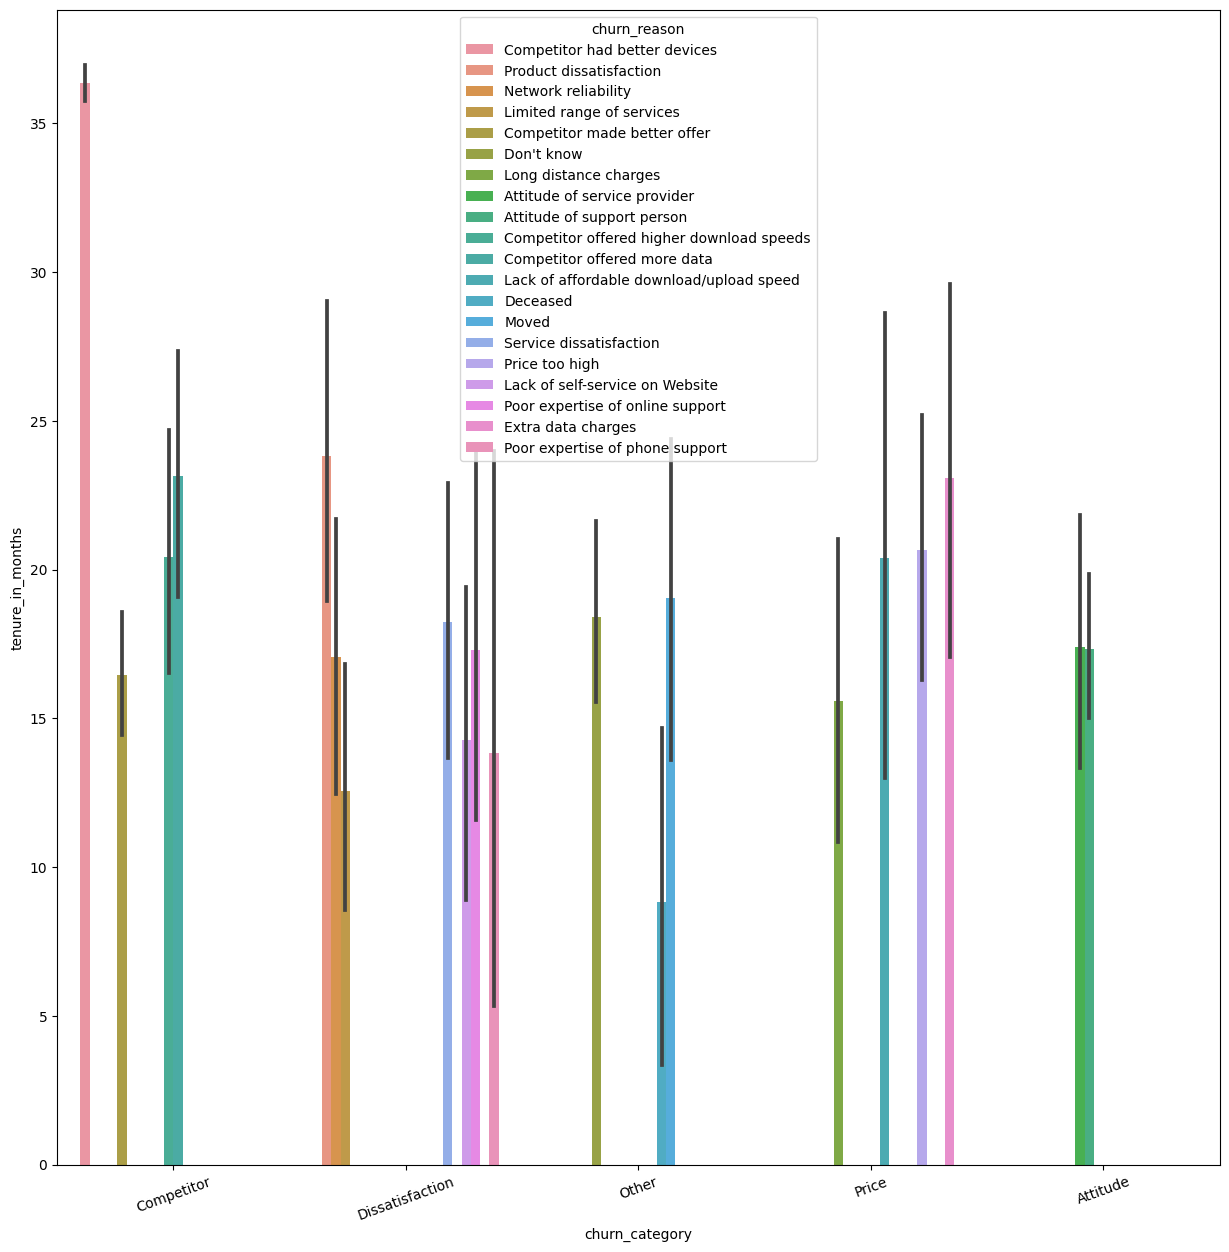

In [109]:
plt.figure(figsize=(15,15))
sns.barplot(x=df.churn_category, y=df.tenure_in_months, hue=df.churn_reason)
plt.xticks(rotation=20)
plt.show()

### 4. Feature Engineering and Selection

In [123]:
# Analyse correlation between the features
corr_matrix = df.corr()
corr_matrix 

,age,number_of_dependents,zip_code,latitude,longitude,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
age,1.000000,-0.119000,-0.008183,-0.010305,0.007612,-0.025141,0.009927,-0.019000,-0.516637,0.134511,0.059684,0.024168,0.025036,0.003065,0.048265
number_of_dependents,-0.119000,1.000000,0.016493,0.029081,-0.024271,0.278003,0.108237,-0.002730,0.248410,-0.125649,0.022535,0.014023,-0.014436,0.068966,0.038038
zip_code,-0.008183,0.016493,1.000000,0.894769,-0.790564,0.001463,0.007146,0.011666,-0.002525,-0.002517,0.001978,-0.003797,-0.014550,0.005063,0.002944
latitude,-0.010305,0.029081,0.894769,1.000000,-0.885979,0.018715,0.011963,0.013701,-0.011995,-0.021613,-0.002784,-0.009901,-0.013233,0.008029,0.000082
longitude,0.007612,-0.024271,-0.790564,-0.885979,1.000000,-0.009893,-0.009672,-0.014641,0.013455,0.021052,0.003811,-0.000597,0.010461,-0.006923,0.001062
number_of_referrals,-0.025141,0.278003,0.001463,0.018715,-0.009893,1.000000,0.326975,0.001712,0.069704,0.026301,0.250378,0.024756,0.000350,0.216190,0.261853
tenure_in_months,0.009927,0.108237,0.007146,0.011963,-0.009672,0.326975,1.000000,0.012100,0.033841,0.239065,0.826074,0.059021,0.082266,0.674149,0.853146
avg_monthly_long_distance_charges,-0.019000,-0.002730,0.011666,0.013701,-0.014641,0.001712,0.012100,1.000000,0.015527,0.018455,0.016546,-0.024869,0.019822,0.525222,0.168531
avg_monthly_gb_download,-0.516637,0.248410,-0.002525,-0.011995,0.013455,0.069704,0.033841,0.015527,1.000000,-0.011866,0.029397,-0.009947,0.015291,0.021568,0.029786
monthly_charge,0.134511,-0.125649,-0.002517,-0.021613,0.021052,0.026301,0.239065,0.018455,-0.011866,1.000000,0.622810,0.023963,0.121238,0.235685,0.563249


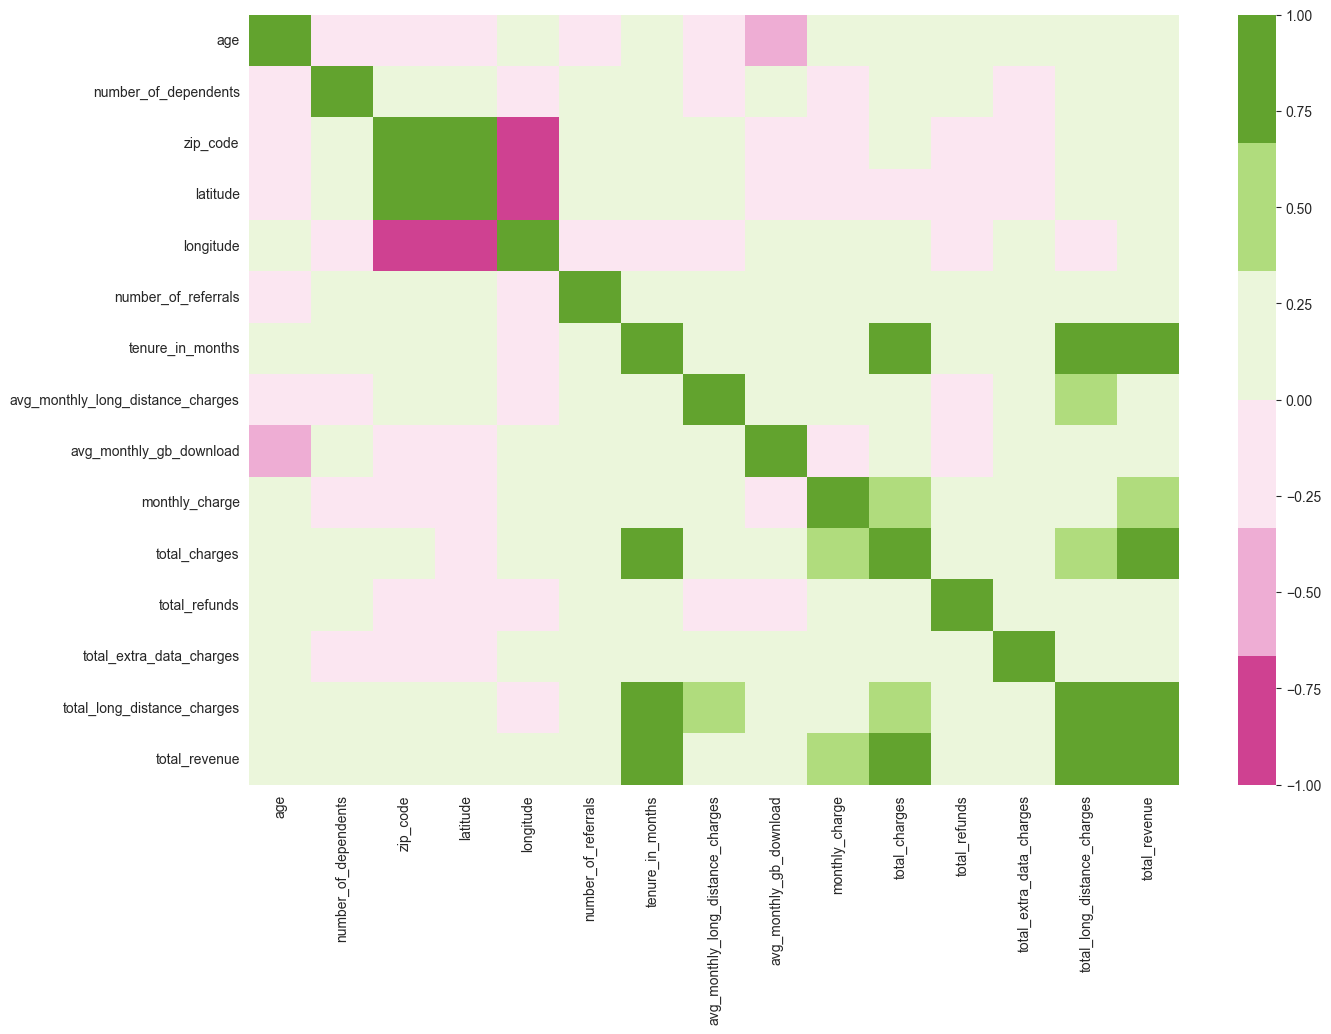

In [129]:
#let's us see the correlation of each feature
plt.figure(figsize=(15, 10))
cmap = sns.color_palette("PiYG")
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap=cmap)
plt.show()

In [ ]:
# I use Ordinal Encoding to encode the value of customer_status
encoder = OrdinalEncoder()
df['customer_status'] = encoder.fit_transform(df[['customer_status']])
df['customer_status'].value_counts()